In [50]:
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

In [19]:
train, val, test = (np.load("../data/task1_%s.npz" % f) 
                    for f in ("train", "val", "test"))
xtr, ytr, xval, yval, xte, yte = (
  torch.from_numpy(arr).float()
  for arr in (train["x"], train["y"], val["x"], val["y"], test["x"], test["y"])
)

In [38]:
# N: number of training samples
# Nh: number of households
# Tin: number of time steps in each window
# Tout: number of time steps in each output
N, Nh, Tin, Tout = *xtr.shape, ytr.shape[-1]

In [71]:
class Mlp(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
  
class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           lstm (nn.LSTM): The LSTM model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state
                           of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a LSTM instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Create additional input dimension
        # x is of shape (N, L)
        x = x[...,None] # (N, L, Hin = 1)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [82]:
#model = Mlp(Tin, 500, Tout)
model = LSTMModel(1, 50, 2, Tout, 0.2)
optimizer = optim.Adam(model.parameters())
train_losses, val_losses = [], []

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


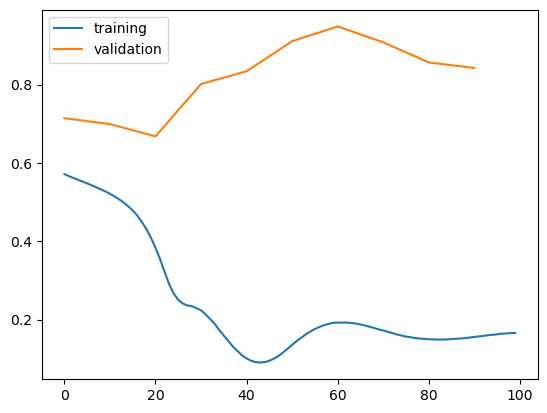

In [83]:
for epoch in trange(100):
  # get training samples
  batch_idx = torch.randint(1, (32,))
  x, y = xtr[batch_idx, 0], ytr[batch_idx, 0]

  # optimize on batch
  model.train()
  y_pred = model(x)
  loss = F.mse_loss(y_pred, y)
  loss.backward()
  optimizer.step()
  train_losses += [[epoch, loss.item()]]

  if epoch % 10 != 0:
    continue

  # evaluate on validation set
  model.eval()
  with torch.no_grad():
    y_pred = model(xval[:,0,...])
    val_rmse = np.sqrt(F.mse_loss(y_pred, yval[:,0,...]))
    val_losses += [[epoch, val_rmse.item()]]

# plot losses
train_losses, val_losses = np.array(train_losses), np.array(val_losses)
plt.plot(train_losses[:,0], train_losses[:,1], label="training")
plt.plot(val_losses[:,0], val_losses[:,1], label="validation")
plt.legend();